# Retinal Cyst detection
## First look at unet


In [1]:
# First make sure you have install these two libraries:
!pip install SimpleITK
!pip install -U pydicom


     |████████████████████████████████| 42.5MB 77.1MB/s 
     |████████████████████████████████| 7.0MB 4.7MB/s 


In [0]:
import requests
import zipfile
from tqdm import tnrange, tqdm_notebook
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
import numpy as np
from PIL import Image
import pydicom as dicom
from IPython import display
import time
from mpl_toolkits.mplot3d import Axes3D
import copy
matplotlib.rcParams['figure.figsize'] = [8, 6]
import scipy.signal

In [3]:
# Only run this code when using Colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load the data

# New Section

In [0]:
# DATA_FOLDER = './cyst_segmentation_ISMI_training_set/'                                  # Local System
DATA_FOLDER = 'gdrive/Team Drives/ISMI-FinalProject/cyst_segmentation_ISMI_training_set/' # Colab

In [5]:
!ls DATA_FOLDER

ls: cannot access 'DATA_FOLDER': No such file or directory


In [6]:
# raw data in ITK format
raw_img_filename = os.path.join(DATA_FOLDER,'images/pat001_im001.mhd')
out_img_filename = os.path.join(DATA_FOLDER,'annotations/pat001_im001.mhd')

# read ITK files using SimpleITK
raw_img = sitk.ReadImage(raw_img_filename)
out_img = sitk.ReadImage(out_img_filename)

# print image information
print('image size: {}'.format(raw_img.GetSize()))
print('image origin: {}'.format(raw_img.GetOrigin()))
print('image spacing: {}'.format(raw_img.GetSpacing()))
print('image width: {}'.format(raw_img.GetWidth()))
print('image height: {}'.format(raw_img.GetHeight()))
print('image depth: {}'.format(raw_img.GetDepth()))

image size: (508, 496, 18)
image origin: (1.3379, 0.00585, 2.70800000219485)
image spacing: (0.011500000022351742, 0.0038999998942017555, 0.24135294556617737)
image width: 508
image height: 496
image depth: 18


In [0]:
# convert the ITK image into numpy format
out_np = sitk.GetArrayFromImage(out_img)
raw_np = sitk.GetArrayFromImage(raw_img)

In [0]:
def get_file_list(path, ext=''):
    return sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(ext)])

def load_img(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path))

In [0]:
from pathlib import Path

In [0]:
# get path names list of raw data in ITK format
x_img_files = get_file_list(Path(DATA_FOLDER,'images/'), 'mhd')
y_img_files = get_file_list(Path(DATA_FOLDER,'annotations/'), 'mhd')


# read ITK files using SimpleITK and conver then into a list of numpy arrays
#X = [load_img(f) for f in x_img_files]
#Y = [load_img(f) for f in y_img_files]

# Code from assignment 7 (Unet)

In [11]:
# Import all libraries
import requests
from tqdm import trange
import zipfile
import os
from PIL import Image
import numpy as np
import pylab as plt
import matplotlib
from random import randint
from scipy.ndimage.interpolation import rotate
from skimage.transform import rescale, resize
from IPython.display import clear_output
import random
import shutil
%matplotlib inline

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input,Dense, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization
from keras import optimizers
from keras.optimizers import SGD, Adam
from keras import regularizers
import keras.callbacks
from keras import backend as K

Using TensorFlow backend.


In [0]:
# adding growth parameter for GPU memory allocation
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
#!pip install comet_ml

In [0]:
class Image:
  
  def __init__(self, img, label=None, name=None, width = None, origin = None, spacing =None):
    '''
    Inputs:
    img: image as a numpy array
    label: labels of the image as np image
    name: the filename of the image
    '''
    self.img = img
    self.label = label
    self.name = name
    self.width = width
    self.origin = origin
    self.spacing = spacing
    
  def get_img(self):
    return self.img
  
  def get_label(self):
    return self.label
  
  def show_img(self):
    plt.subplot(1, 2, 1)
    print(self.img.shape)
    plt.imshow(self.img.reshape(256,256)); plt.title('RGB image')
    plt.subplot(1, 2, 2)
    plt.imshow(self.label.reshape(256,256),cmap='Greys'); plt.title('Label')
    plt.show()
  def get_name():
    return self.name
  

In [0]:
def pad_n_crop_(img, cropx, cropy):
  #print(img.shape)
  #img = np.pad(img, ((0,0),(0,0),(0,0)), mode='edge')
  #maybe do not pad? 
  #print(img.shape)
  _, y,x = img.shape
  startx = x//2-(cropx//2)
  starty = y//2-(cropy//2)    
  return img[:, starty:starty+cropy,startx:startx+cropx]

In [0]:

validation_percent = 0.2 
n_validation_files = int(validation_percent * len(x_img_files))
#NEED A CLEAN CUT HERE BETWEEN VOLUMES
# coefficient to define validation dataset (value between 0 and 1)
# Do this with a more random split

train_x_files = x_img_files[n_validation_files:]
train_y_files = y_img_files[n_validation_files:]

validation_x_files = x_img_files[:n_validation_files]
validation_y_files = y_img_files[:n_validation_files]

In [0]:
validation_data = []
train_data =[]

for x_file, y_file in zip(train_x_files, train_y_files):
  img = load_img(x_file).astype('float32')
  img = pad_n_crop_(img, 256, 256).reshape(img.shape[0],256,256,1)/255.
  label = load_img(y_file)
  label = pad_n_crop_(label, 256, 256)
  name = x_file.split('/')[-1]
  for i in range(img.shape[0]):
    #print(img.shape)
    image = Image(img[i,:,:], label[i,:,:], name)
    #print(image.get_img().shape)
    train_data.append(image)
    
for x_file, y_file in zip(validation_x_files, validation_y_files):
  img = load_img(x_file).astype('float32')
  img = pad_n_crop_(img, 256, 256).reshape(img.shape[0],256,256,1)/255.
  label = load_img(y_file)
  label = pad_n_crop_(label, 256, 256)
  name = x_file.split('/')[-1]
  for i in range(img.shape[0]):
    #print(img.shape)
    image = Image(img[i,:,:], label[i,:,:], name)
    #print(image.get_img().shape)
    validation_data.append(image)
  

In [0]:
from sklearn.utils import class_weight
import keras.preprocessing.image as kim

In [0]:
def augment_image(img, lbl):
    func_list = [rotate_image, flip_image]
    return random.choice(func_list)(img, lbl)
        
def rotate_image(img, lbl, rotationSize=15):
    lbl = lbl.reshape(tuple(list(lbl.shape) + [1]))
    img = kim.random_rotation(img,rotationSize, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    lbl = kim.random_rotation(lbl,rotationSize, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    return img , lbl[:,:,0]

def flip_image(img, lbl):
    flipped_img = np.fliplr(img)
    flipped_lbl = np.fliplr(lbl)
    return flipped_img, flipped_lbl

In [0]:
img, lbl = augment_image(train_data[0].img, train_data[0].label)

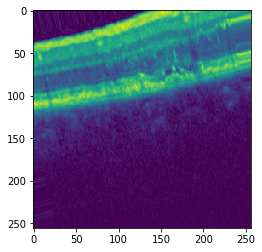

In [53]:
plt.imshow(img.reshape(256,256))

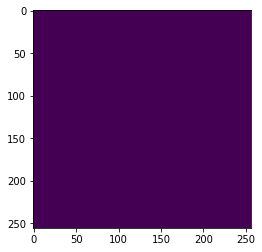

In [32]:
plt.imshow(train_data[0].label.reshape(256,256))

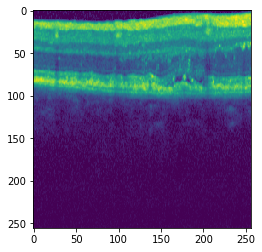

In [33]:
plt.imshow(train_data[0].img.reshape(256,256))

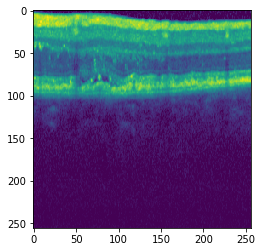

In [21]:
plt.imshow(np.fliplr(train_data[0].img.reshape(256,256)))

In [0]:
class BatchCreator:
    
    def __init__(self, dataset, target_size):
        #self.patch_extractor = patch_extractor
        self.target_size = target_size # size of the output, can be useful when valid convolutions are used
        
        self.imgs = [image.img for image in dataset]
        self.lbls = [image.label for image in dataset]
                
        self.n = len(self.imgs)
        #self.patch_size = self.patch_extractor.patch_size
    
    def create_image_batch(self, batch_size):
        '''
        returns a single augmented image (x) with corresponding labels (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, 256,256, 1))
        y_data = np.zeros((batch_size, 256,256, 2)) # one-hot encoding with 2 classes
        sw = np.zeros((batch_size,1,1,1))
        for i in range(0, batch_size):
        
            random_index = np.random.choice(len(self.imgs)) # pick random image
            img, lbl = self.imgs[random_index], self.lbls[random_index] # get image and segmentation map
            
           # clear_output()
            #patch_img, patch_lbl = self.patch_extractor.get_patch(img, lbl) # when image size is equal to patch size, this line is useless...
          #  img, lbl = 
            # crop labels based on target_size
            #h, w, _ = patch_lbl.shape
            #ph = (self.patch_extractor.patch_size[0] - self.target_size[0]) // 2
            #pw = (self.patch_extractor.patch_size[1] - self.target_size[1]) // 2
            #patch_img = patch_img.reshape(tuple(list(patch_img.shape) + [1]))
            r = random.random()
           # if r > 0.8:
           #   img, lbl = augment_image(img, lbl)
            unique, counts = np.unique(img, return_counts=True)
            w_background = 0.5 / (counts[0]/(np.sum(counts)))
            w_foreground = 0.5 / (counts[1]/(np.sum(counts)))
            x_data[i, :, :, :] = img
            y_data[i, :, :, 0] = 1 - lbl
            y_data[i, :, :, 1] = lbl
            sw[i,0,:,:] =  w_foreground
            sw[i,:,0,:] = w_background
            #print(len(y_data.shape))
            #maybe just return one y_data? 
        return (x_data.astype(np.float32), y_data.astype(np.float32), sw.flatten())
    
    def get_image_generator(self, batch_size):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch(batch_size)

In [0]:
def crop(masks, lost_border):
    ph = lost_border[0] // 2
    pw = lost_border[1] // 2
    h, w = masks[0].shape    
    return np.array(masks)[:, ph:h-ph, pw:w-pw]   

def calculate_dice(x, y):
    '''returns the dice similarity score, between two boolean arrays'''
    return 2 * np.count_nonzero(x & y) / (np.count_nonzero(x) + np.count_nonzero(y))
    
class Logger(keras.callbacks.Callback):

    def __init__(self, validation_data, lost_border, data_dir, model_name):
        self.val_imgs = np.array([image.img for image in validation_data]) 
        self.val_lbls = crop([image.label for image in validation_data], lost_border)
        self.model_filename = os.path.join(data_dir, model_name + '.h5')
        
        self.losses = []
        self.val_losses = []
        self.dices = []
        self.val_dices = []
        self.best_dice = 0
        self.best_model = None
        
        self.predictions = None
    
    def on_batch_end(self, batch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.losses.append(logs.get('loss'))
    
    def on_epoch_end(self, batch, logs={}):
        dice = self.validate()
        self.dices.append([len(self.losses), dice])
        if dice > self.best_dice:
            self.best_dice = dice
            self.model.save(self.model_filename) # save best model to disk
            print('best model saved as {}'.format(self.model_filename))
        self.plot()   
        print(self.best_dice)
    
    def validate(self):
        self.predictions = self.model.predict(self.val_imgs, batch_size=1)
        predicted_lbls = np.argmax(self.model.predict(self.val_imgs, batch_size=1), axis=3)
        x = self.val_lbls>0
        y = predicted_lbls>0
        return calculate_dice(x, y)
    
    def plot(self):
        clear_output()
        N = len(self.losses)
        plt.figure(figsize=(50, 10))
        plt.subplot(1, 5, 1)
        plt.plot(range(0, N), self.losses); 
        plt.plot(range(0, N), self.val_losses); 
        plt.legend(['loss', 'val_loss'], loc='upper left')
        plt.subplot(1, 5, 2)
        plt.plot(*np.array(self.dices).T); plt.title('dice')
        plt.show()

In [0]:
from sklearn import preprocessing


(6, 256, 256, 1)
(6, 256, 256, 2)
(256, 256)


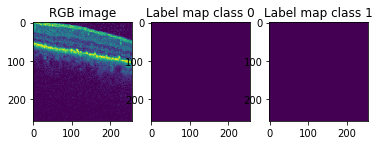

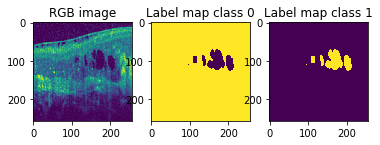

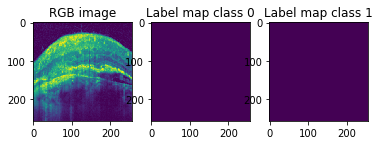

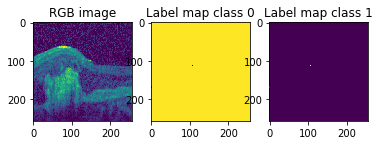

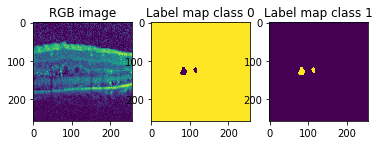

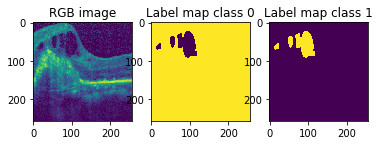

In [101]:
# define parameters for patch generator and batch creator
#patch_size = (32, 32) # input size
target_size = (256, 256) # output size, might be the same as input size, but might be smaller, if valid convolutions are used
batch_size =  6 # number of patches in a mini-batch

# intialize patch generator and batch creator
#patch_generator = PatchExtractor(patch_size)
batch_generator = BatchCreator(train_data, target_size=target_size)
validation_generator = BatchCreator(validation_data, target_size=target_size)
# get one minibatch
x_data, y_data, sw = validation_generator.create_image_batch(batch_size)

print(x_data.shape)
print(y_data.shape)
print(y_data[0, :, :, 0].squeeze().shape)
for i in range(batch_size):
    plt.subplot(1, 3, 1)
    plt.imshow(x_data[i].reshape(256,256)); plt.title('RGB image')
    plt.subplot(1, 3, 2)
    plt.imshow(y_data[i, :, :, 0].squeeze()); plt.title('Label map class 0')
    plt.subplot(1, 3, 3)
    plt.imshow(y_data[i, :, :, 1].squeeze()); plt.title('Label map class 1')
    plt.show()

In [0]:
# Create a function that builds a U-Net block, containing conv->(batchnorm->)conv->(batchnorm),
# where batchnorm is optional and can be selected via input parameter.
# The function returns the output of a convolutional (or batchnorm) layer "cl"
def unet_block(inputs, n_filters, batchnorm=False, name= None):
    
    # >> YOUR CODE HERE <<
    cl = Conv2D(n_filters,3, activation = 'relu', padding = 'same',kernel_initializer ='he_normal', name = name+"1" )(inputs)
    cl = BatchNormalization()(cl) if batchnorm else cl
    cl = Conv2D(n_filters,3,activation = 'relu', padding = 'same',kernel_initializer='he_normal',name = name+"2")(cl)
    cl = BatchNormalization()(cl) if batchnorm else cl
    
    return cl

In [0]:
def build_unet_2(initial_filters=32, n_classes=2, batchnorm=False, printmodel=False):

    # build U-Net again using unet_block function
    inputs = Input(shape=(256, 256, 1))

    # CONTRACTION PART

    # First conv pool
    c1 = unet_block(inputs, initial_filters, batchnorm,name ='first')
    p1 = MaxPooling2D()(c1)

    # Second conv pool
    c2 = unet_block(p1, 2*initial_filters, batchnorm,name='second')
    p2 = MaxPooling2D()(c2)

    # Third conv pool
    c3 = unet_block(p2, 4*initial_filters, batchnorm,name='third')
    p3 = MaxPooling2D()(c3)

    # Fourth conv
    c4 = unet_block(p3, 8*initial_filters, batchnorm, name='fourth')

    # EXPANSION PART

    # First up-conv
    u2 = UpSampling2D()(c4)
    m2 = concatenate([c3, u2])
    cm2 = unet_block(m2, 4*initial_filters, batchnorm, name ='fifth')

    # Second up-conv
    u3 = UpSampling2D()(cm2)
    m3 = concatenate([c2, u3])
    cm3 = unet_block(m3, 2*initial_filters, batchnorm, name ='sixth')

    # Third up-conv
    u4 = UpSampling2D()(cm3)
    m4 = concatenate([c1, u4])
    cm4 = unet_block(m4, initial_filters, batchnorm, name = 'seventh')

    # Output
    predictions = Conv2D(n_classes, 1, activation='softmax', name = 'last')(cm4)

    model = Model(inputs, predictions)
    
    if printmodel:
        print(model.summary())
    
    return model

In [0]:
unet_1 = build_unet_2()

In [0]:
def apply_model(model, dataset, experiment_name='basic_unet', make_submission_file=False):
    """Apply a given model to the test set, optionally makes a submission file in ZIP format."""
    
    output_dir = os.path.join('.', experiment_name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    imgs = [image.img for image in dataset]

    for i in range(len(imgs)):
        fig = plt.figure(figsize=(10,20))
        input_img = np.expand_dims(imgs[i], axis=0)
        output = model.predict(input_img, batch_size=1)[0, :, :]
        plt.subplot(1, 2, 1); plt.imshow(imgs[i].reshape(256,256))
        plt.subplot(1, 2, 2); plt.imshow(np.argmax(output, axis=2))
        if make_submission_file:
            prediction = Image.fromarray(np.argmax(output, axis=2).astype(np.uint8))
            prediction.save(os.path.join(output_dir, '{}.png'.format(i)))
        plt.show()
        
    if make_submission_file:
        shutil.make_archive('results', 'zip', output_dir)

In [0]:
# apply the model to the validation set
data_dir = '.'
#apply_model(unet_1, validation_data)

In [0]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [0]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=40, min_delta=0.001, min_lr=0.00001) #should be val_loss later

In [0]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=80, 
                                  verbose=0, mode='auto', baseline=None, restore_best_weights=False) # shoud be val_loss later

In [0]:
val_imgs = []
val_lbls = []
for v in validation_data:
  val_imgs.append(v.img.reshape(256,256,1))
  label = np.zeros((256,256, 2))
  label[:,:,0] = v.label
  label[:,:,1] = 1- v.label
  val_lbls.append(label)

In [0]:
# function to train a model
def train_model(model, training_params):
    
    patch_size = training_params['patch_size']
    target_size = training_params['target_size']
    batch_size = training_params['batch_size']
    loss = training_params['loss']
    metrics = training_params['metrics']
    logger = training_params['logger']
    epochs = training_params['epochs']
    steps_per_epoch = training_params['steps_per_epoch']
    optimizer = training_params['optimizer']
    training_dataset = training_params['training_dataset']
    validation_dataset = training_params['validation_dataset']
    # batch generator 
    #patch_generator = PatchExtractor(patch_size)
    batch_generator = BatchCreator(training_dataset, target_size=target_size)
    image_generator = batch_generator.get_image_generator(batch_size)
    validation_generator = BatchCreator(validation_dataset, target_size=target_size)
    val_generator = validation_generator.get_image_generator(batch_size)



    # compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # train the model
    model.fit_generator(generator=image_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        #class_weight = [0000.5,500000],
                        #class_weight = class_weight,
                        epochs=epochs,
                        validation_data = val_generator,
                        validation_steps = len(validation_data)/batch_size,
                        callbacks=[logger,reduce_lr,early_stop])

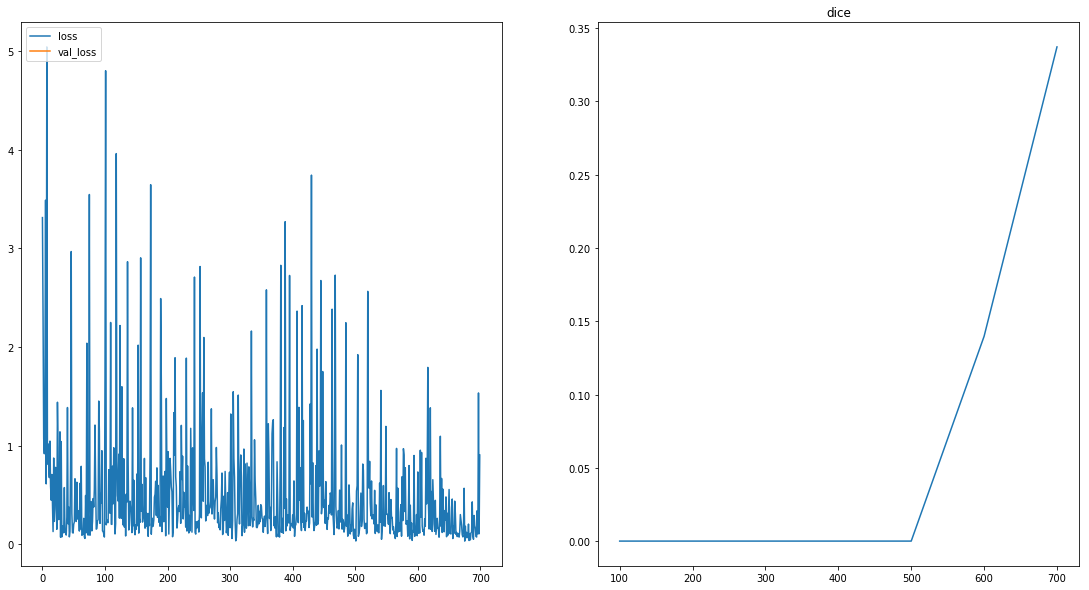

0.3371563330611019
Epoch 8/5000
 80/100 [=======================>......] - ETA: 2s - loss: 0.2734 - acc: 0.9838

In [0]:
# training parameters
unet_1 = build_unet_2()
model_name = 'unet_1'

training_params = {}
training_params['learning_rate'] = 0.001
training_params['patch_size'] = (256, 256) # input size
training_params['target_size'] = (256, 256) # output size, might be the same as input size, but might be smaller, if valid convolutions are used
training_params['batch_size'] = 6 # number of patches in a mini-batch
training_params['steps_per_epoch'] = 100 # number of iterations per epoch
training_params['epochs'] = 5000 # number of epochs

training_params['optimizer'] = SGD(lr=training_params['learning_rate'], momentum=0.99, nesterov=True)
training_params['loss'] = ['categorical_crossentropy']
#training_params['loss'] = weightedLoss(['categorical_crossentropy'],[5000,0.0001])
training_params['metrics'] = ['acc']
training_params['training_dataset'] = train_data
training_params['validation_dataset'] = validation_data

# initialize a logger, to keep track of information during training
lost_border = ((training_params['patch_size'][0]-training_params['target_size'][0])//2, (training_params['patch_size'][1]-training_params['target_size'][1])//2)
training_params['logger'] = Logger(validation_data, lost_border, data_dir, model_name)

# train model
train_model(unet_1, training_params)

In [0]:

wt_path2 = os.path.join(os.getcwd(), 'unet_1.h5')
unet_1.load_weights(wt_path2)
print("Weights loaded from disk")

In [0]:
#apply_model(unet_1, validation_data)

In [0]:
TEST_FOLDER = 'gdrive/Team Drives/ISMI-FinalProject/cyst_segmentation_ISMI_test_set/cyst_segmentation_ISMI_test_set/' # Colab

In [0]:
!ls 'gdrive/Team Drives/ISMI-FinalProject/cyst_segmentation_ISMI_test_set/cyst_segmentation_ISMI_test_set/'

images


In [0]:
def pad_prediction(prediction, input_size, pad_with=-0.0):
    """Only for visualization purpose, it introduces artificial -1."""
    pad_pred = pad_with * np.ones(input_size).astype(float)
    pred_size = prediction.shape
    D = ((input_size[0]-pred_size[0])//2, (input_size[1]-pred_size[1])//2)
    pad_pred[D[0]:D[0]+pred_size[0], D[1]:D[1]+pred_size[1]] = prediction
    return pad_pred

In [0]:
x_test_files = get_file_list(os.path.join(TEST_FOLDER,'images/'), 'mhd')
test_imgs = []
origins = []
spacings =[]
names = []
for t in x_test_files:
  img = load_img(t).astype('float32')
  width = img.shape[2]
  raw = sitk.ReadImage(t)
  origins.append(raw.GetOrigin())
  spacings.append(raw.GetSpacing())
  img = pad_n_crop_(img, 256, 256).reshape(img.shape[0],256,256,1)/255.
  temp = t.split('/')[-1]
  name = temp.split('.')[0]
  names.append(temp.split('.')[0])
  for i in range(img.shape[0]):
    #print(img.shape)
    image = Image(img[i,:,:], name = name, width=width)
    #print(image.get_img().shape)
    test_imgs.append(image)

In [0]:
print(test_imgs[55].name)

pat077_im003


In [0]:
p = []
for i in test_imgs:
  x = unet_1.predict(i.img.reshape(1,256,256,1))
 ## xx = np.argmax(x,axis=3)
  xx = Image(pad_prediction(np.argmax(x,axis=3).reshape(256,256),(496,i.width), pad_with=0.0),name=i.name, width = i.width)
  p.append(xx)

In [0]:
k = load_img(x_test_files[14]).astype('float32')

In [0]:

keks = []
for isa in range(k.shape[0]):
  keks.append(k[isa,:,:])

In [0]:
len(keks)

18

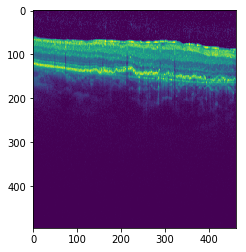

In [0]:
for i in keks:
  plt.imshow(i)

In [0]:
names = []
for n in p:
  names.append(n.name)

In [0]:
unique,counts = np.unique(names,return_counts=True)

In [0]:
print(unique)

['pat077_im001' 'pat077_im002' 'pat077_im003' 'pat078_im001'
 'pat079_im001' 'pat080_im001' 'pat081_im001' 'pat082_im001'
 'pat082_im002' 'pat083_im001' 'pat084_im001' 'pat084_im002'
 'pat085_im001' 'pat085_im002' 'pat085_im003' 'pat085_im004'
 'pat085_im005' 'pat085_im006' 'pat086_im001' 'pat086_im002'
 'pat086_im003' 'pat086_im004' 'pat087_im001' 'pat087_im002'
 'pat088_im001' 'pat088_im002' 'pat089_im001' 'pat089_im002'
 'pat089_im003' 'pat090_im001' 'pat091_im001' 'pat091_im002'
 'pat092_im001' 'pat093_im001' 'pat094_im001' 'pat095_im001'
 'pat096_im001' 'pat097_im001' 'pat098_im001' 'pat098_im002'
 'pat099_im001' 'pat100_im001' 'pat101_im001' 'pat102_im001'
 'pat103_im001' 'pat103_im002' 'pat104_im001' 'pat105_im001'
 'pat105_im002' 'pat106_im001' 'pat107_im001' 'pat108_im001']


In [0]:
volumes = []
for u in unique: 
   volume = []
   for pic in p:
     if pic.name == u:
        volume.append(pic.img)
   volumes.append(volume)

1462

In [0]:
def save_itk(image,spacing, origin, filename):
    itkimage = sitk.GetImageFromArray(image, isVector=False)
    itkimage.SetSpacing(spacing)
    itkimage.SetOrigin(origin)
    sitk.WriteImage(itkimage, filename) 
    

In [0]:
!mkdir "manman"

In [0]:
for v in range(len(volumes)):
  r = random.random()
  output_file_name = os.path.join('manman', str.replace('test_x.mhd','test_x',str(v)))
  save_itk(volumes[v],spacings[v],origins[v],output_file_name)

In [0]:
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

if __name__ == '__main__':
    zipf = zipfile.ZipFile('manman.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir('manman', zipf)
    zipf.close()


In [0]:
DATA_FOLDER = 'new_tests/' # Colab

In [0]:
# get path names list of raw data in ITK format
xxx = get_file_list(Path(DATA_FOLDER,'.'), 'mhd')


In [0]:
sexy = []
for x_file in xxx:
  img = load_img(x_file).astype('float32')
  print(img.shape)
  img = pad_n_crop_(img, 256, 256).reshape(img.shape[0],256,256,1)/255.
  for i in range(img.shape[0]):
    #print(img.shape)
    image = Image(img[i,:,:])
    #print(image.get_img().shape)
    sexy.append(image)

In [0]:
for i in range(len(sexy)):
    fig = plt.figure(figsize=(10,20))
    plt.subplot(1, 2, 1); plt.imshow(sexy[i].img.reshape(256,256))
    plt.show()